## Vehicle Detection Project

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

In [1]:
import os
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

## Load data

In [2]:
def load_images(basedir):
    """
    Images are divided up into vehicles and non-vehicles folders, 
    each of which contains subfolders. Different folders represent 
    different sources for images (eg. GTI, kitti, generated by me,...).
    """
    image_types = os.listdir(basedir)
    res = []
    for imtype in image_types:
      res.extend(glob.glob(basedir + imtype + '/*'))
    return res

cars = load_images('./vehicles/')
print('Number of vehicle images found: {}'.format(len(cars)))

notcars = load_images('./non-vehicles/')
print('Number of non-vehicle images found: {}'.format(len(notcars)))

searchpath = 'images_video/vehicle_det_examples/*'
example_images = glob.glob(searchpath)
print('Number of example images: {}'.format(len(example_images)))

Number of vehicle images found: 8792
Number of non-vehicle images found: 8968
Number of example images: 8


## Utils

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    """
    Function to return HOG features and visualization.
    
    Call with two outputs if vis==True, otherwise call with one output
    
    The histogram of oriented gradients (HOG) is a feature 
    descriptor used in computer vision and image processing 
    for the purpose of object detection. The technique counts 
    occurrences of gradient orientation in localized portions 
    of an image. This method is similar to that of edge 
    orientation histograms, scale-invariant feature transform 
    descriptors, and shape contexts, but differs in that it is 
    computed on a dense grid of uniformly spaced cells and uses 
    overlapping local contrast normalization for improved accuracy.
    
    Source: https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients
    """
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [4]:
def bin_spatial(img, size=(32, 32)):
    """
    Function to compute binned color features.
    It takes an image, a color space, and a new image size
    and returns a feature vector
    """
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [5]:
def color_hist(img, nbins=32):
    """
    Function to compute the color histogram features:    
     1. Compute the histogram of the RGB channels separately.
     2. Concatenate the histograms into a single feature vector.
     3. Return the individual histograms, bin_centers and feature vector.
    """
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [6]:
def visualize(fig, rows, cols, imgs, titles):
    """
    Function for plotting multiple images.
    """
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i + 1)
        plt.title(i + 1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
        else:
            plt.imshow(img)
        plt.title(titles[i])

In [7]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

In [8]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Function to draw bounding boxes
      1. Make a copy of the image.
      2. Iterate through the bounding boxes and draw a 
         rectangle given bbox coordinates.
      3. Return the image copy with boxes drawn.
    """
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

## Feature extraction

In order to detect our objects of interest, we need to know what differentiates them from the rest of the image. Things like colors and gradients can be good differentiators but lets give them an identity. All of these potential characteristics are features that we could use. What features are more important may depend upon the appearance of the objects in question.

In most applications, we'll end up using a combination of features that give the best results.

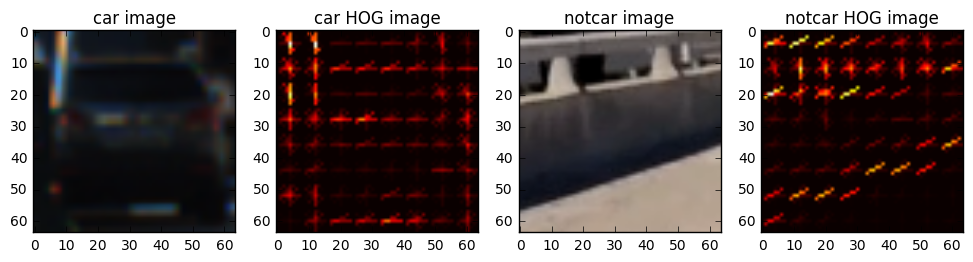

In [9]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,
                        vis=False):    
    """
    Function to extract features from a single image window:
      1. Define an empty list to receive features
      2. Apply color conversion if other than 'RGB'
      3. Compute spatial features if flag is set
      4. Compute histogram features if flag is set    
      5. Compute HOG features if flag is set
      6. Return concatenated array of features    
    """
    img_features = []
    
    if color_space != 'RGB':
        feature_image = convert_color(img, color_space)
    else: 
        feature_image = np.copy(img)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)

    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)

    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)

    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)
    
def test_single_img_features():
    """
    Test features extraction from a single image window:
      1. Choose random car & not-car indices.
      2. Read in car & notcar images.
      3. Define feature parameters.
      4. Extract the features for car & not-car.
      5. Visualize them.
    """
    %matplotlib inline

    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))

    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])

    color_space = 'RGB'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 6  # HOG orientations
    pix_per_cell = 8  # HOG pixels per cell
    cell_per_block = 2  # HOG cells per block
    hog_channel = 0  # Can be 0,1,2, or "ALL"
    spatial_size = (16, 16)  # spatial binning dimensions
    hist_bins = 16  # number of histogram bins
    spatial_feat = True  # Spatial features on or off
    hist_feat = True  # Histogram features on or off
    hog_feat = True  # HOG features on or off

    car_feature, car_hog_image = single_img_features(car_image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
    notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

    images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
    titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
    fig = plt.figure(figsize=(12, 3)) 
    visualize(fig, 1, 4, images, titles)
    
test_single_img_features()

In [10]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Extract the features of a list of images.
    """
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        img_features = single_img_features(image, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat, vis=False)
            
        features.append(img_features)
    return features

## Classification model

Now that we've extracted suitable features from an image, let's use them to detect cars.

A classic approach is to first design a classifier that can differentiate car images from non-car images, and then run that classifier across an entire frame sampling small patches along the way.

In [11]:
def train_model():
    ### TODO: Tweak these parameters and see how the results change.
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

    t = time.time()
    n_samples = 1000
    random_idxs = np.random.randint(0, len(cars), n_samples)
    test_cars = cars  
    test_notcars = notcars

    car_features = extract_features(test_cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(test_notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    print(time.time() - t, 'seconds to cumpute features...')

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations', pix_per_cell,
        'pixels per cell and', cell_per_block, 'cells per block',
         hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
    print('Feature vector length:', len(X_train[0]))

    # Use a linear SVC 
    svc = LinearSVC()
    
    # Check the training time for the SVC
    t = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to train SVC...')
    
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))    
    
    return svc, X_scaler
    
model, scaler = train_model()

113.2536849975586 seconds to cumpute features...
Using: 9 orientations 8 pixels per cell and 2 cells per block 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
21.56 Seconds to train SVC...
Test Accuracy of SVC =  0.9932


## Detection

In [12]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    This function takes an image, start and stop positions in both x and y, 
    window size (x and y dimensions), and overlap fraction (for both x and y)
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))

    return window_list

In [15]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    """
    Given an image and the list of windows to be 
    searched (output of slide_windows()),
    returns windows for positive detections:
      1. Foreach window in list:
        2. Extract the test window from original image
        3. Extract features for that window using single_img_features()
        4. Scale extracted features to be fed to classifier.
        5. Predict using your classifier.
        6. If positive (prediction == 1) then save the window.
    """
    on_windows = []
    for window in windows:        
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
            
    return on_windows

0.0 1.0
0.8952608108520508 seconds to process one image searching 190 windows
0.0 1.0
1.2954540252685547 seconds to process one image searching 190 windows
0.0 1.0
0.9630870819091797 seconds to process one image searching 190 windows
0.0 1.0
1.1580588817596436 seconds to process one image searching 190 windows
0.0 1.0
1.0590319633483887 seconds to process one image searching 190 windows
0.0 1.0
0.8816871643066406 seconds to process one image searching 190 windows
0.0 1.0
0.8971798419952393 seconds to process one image searching 190 windows
0.0 1.0
1.3720860481262207 seconds to process one image searching 190 windows


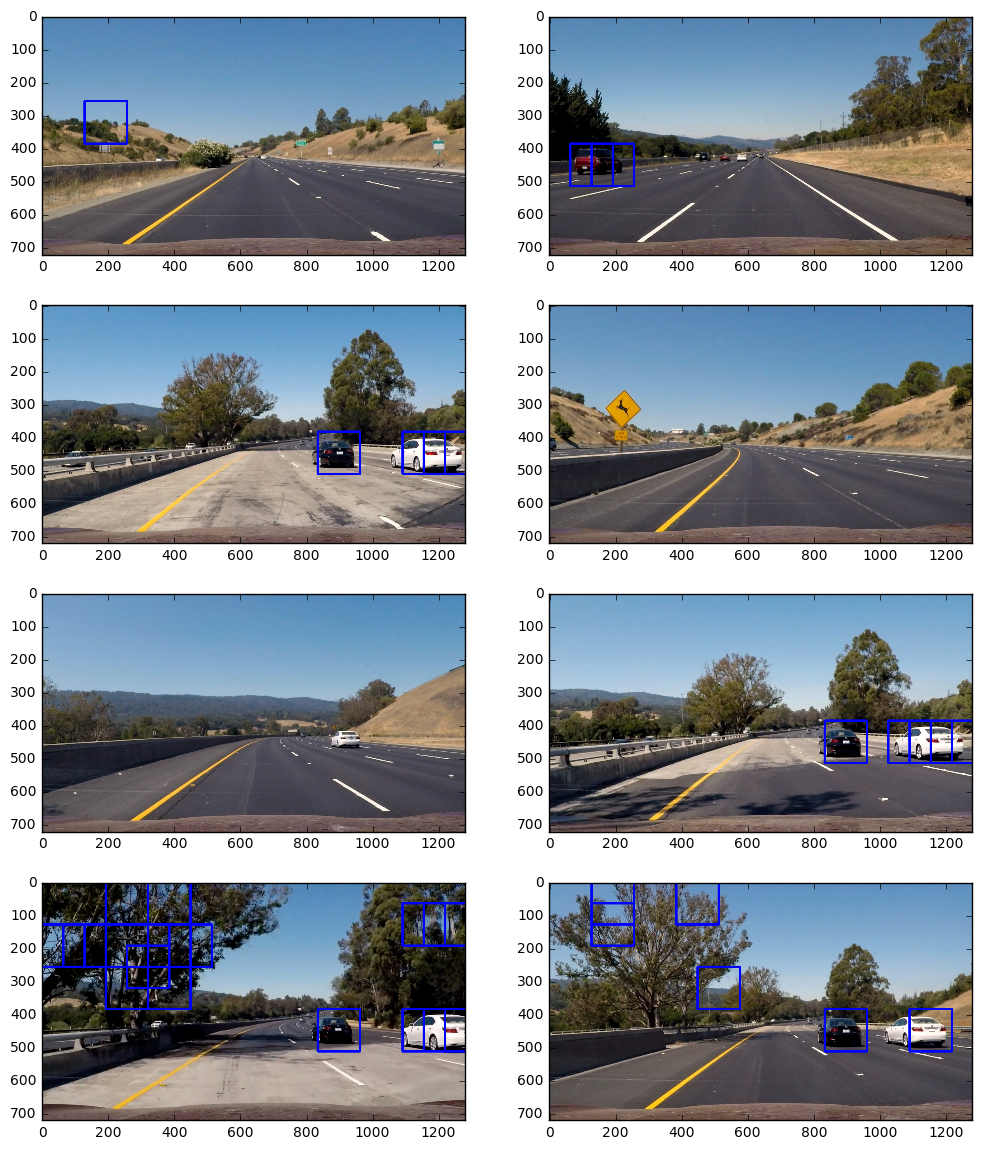

In [16]:
def test_slide_window(example_images):
    ### TODO: Tweak these parameters and see how the results change.
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

    images = []
    titles = []
    y_start_stop = [None, None] # Min and max in y to search in slide_window()
    # provar 400, 656
    overlap = 0.5
    for img_src in example_images:
        t1 = time.time()
        img = mpimg.imread(img_src)
        draw_img = np.copy(img)

        # Uncomment the following line if you extracted training
        # data from .png images (scaled 0 to 1 by mpimg) and the
        # image you are searching is a .jpg (scaled 0 to 255)
        # image = image.astype(np.float32)/255
        img = img.astype(np.float32)/255
        print(np.min(img), np.max(img))

        windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(128, 128), xy_overlap=(overlap, overlap))
                            # provar 64,64
                            # provar 96,96
        hot_windows = search_windows(img, windows, model, scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)                       

        window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)                    
        images.append(window_img)
        titles.append('')
        print(time.time() - t1, 'seconds to process one image searching', len(windows), 'windows')

    fig = plt.figure(figsize=(12,18), dpi=300)
    visualize(fig, 5, 2, images, titles);

test_slide_window(example_images)

Testing Find Cars...
0.497952938079834 seconds to run, total windows = 0
0.372499942779541 seconds to run, total windows = 0
0.38160109519958496 seconds to run, total windows = 0
0.37970614433288574 seconds to run, total windows = 0
0.37000489234924316 seconds to run, total windows = 0
0.35376906394958496 seconds to run, total windows = 0
0.4455869197845459 seconds to run, total windows = 0
0.6690499782562256 seconds to run, total windows = 0


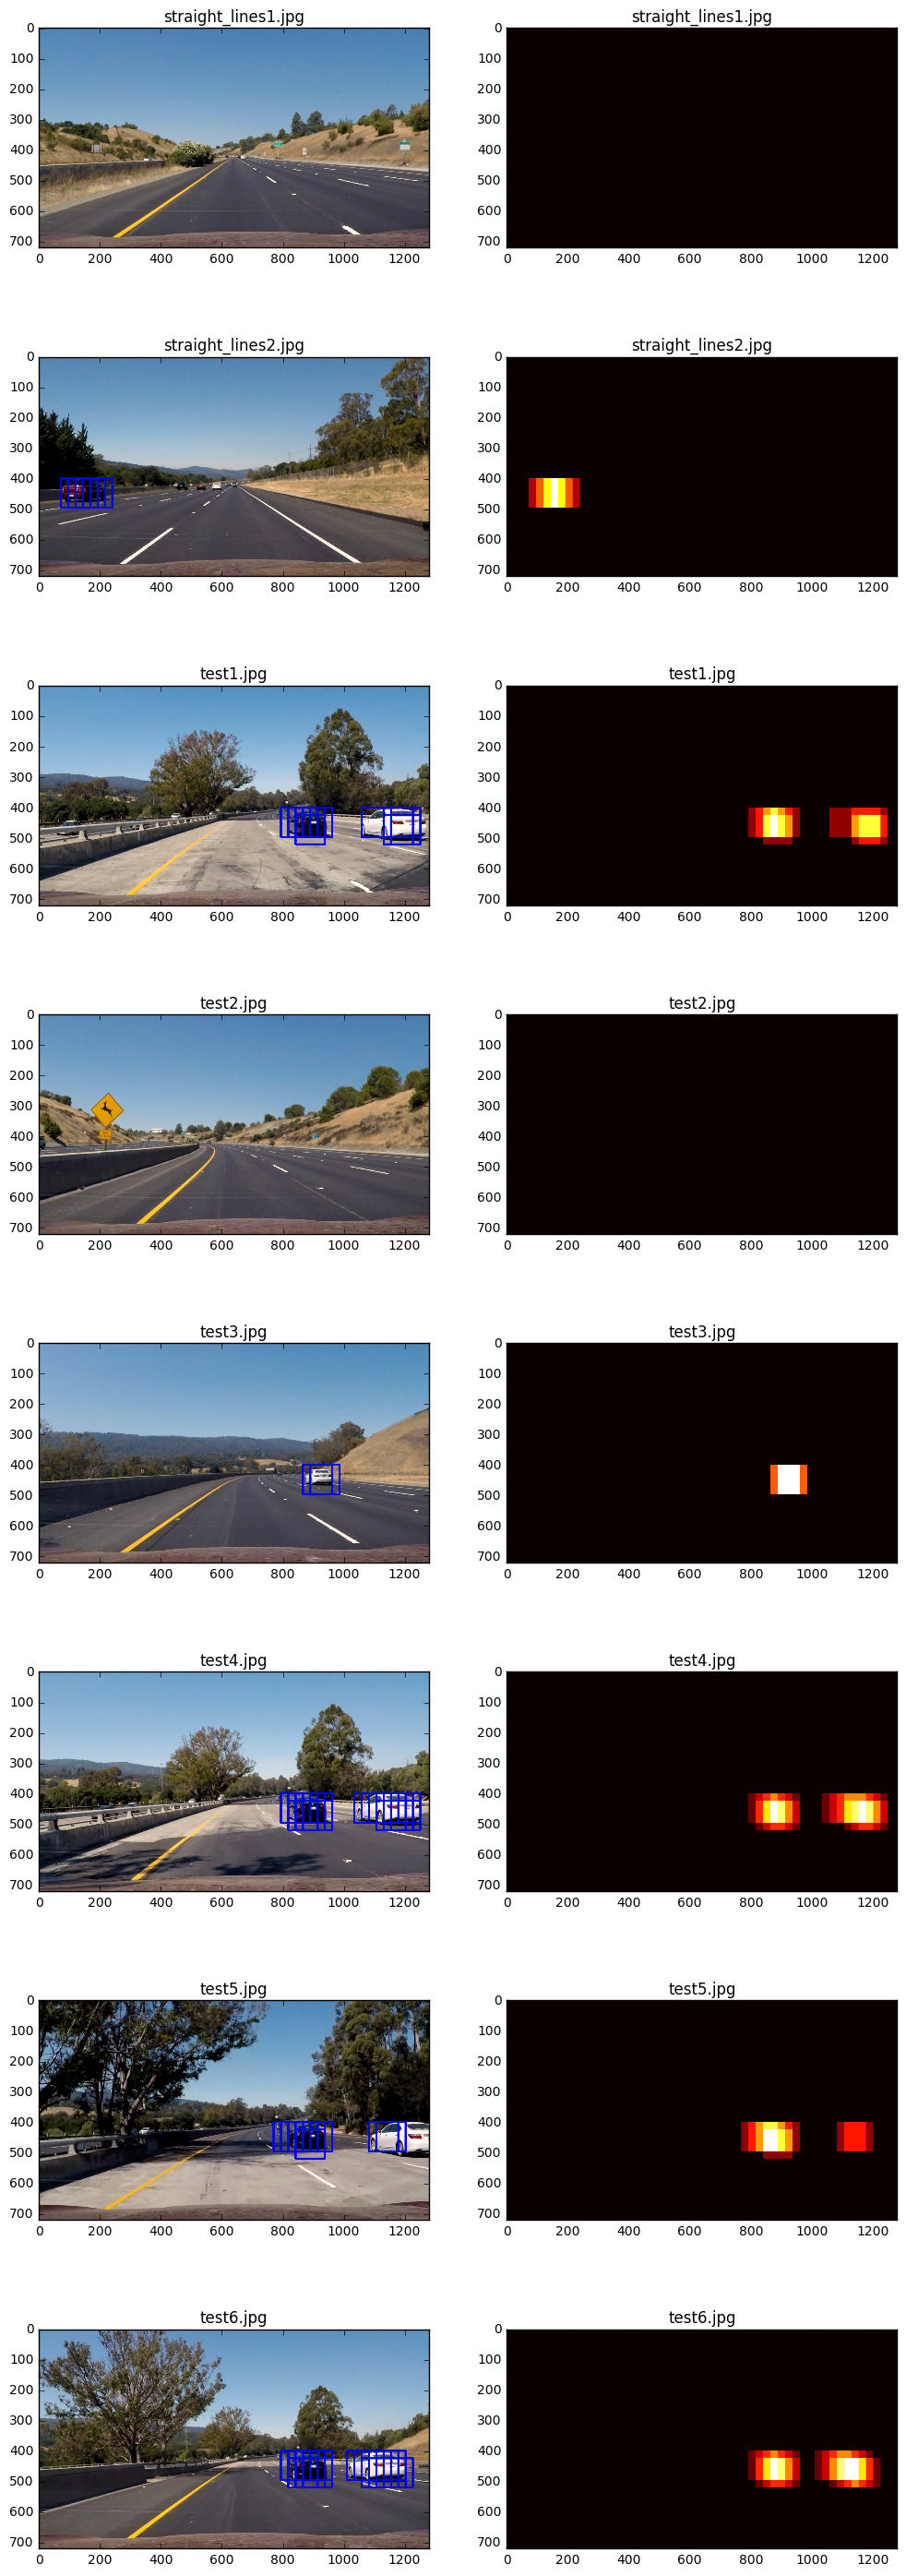

In [17]:
def find_cars(img, ystart, ystop, scale):
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    
    draw_img = np.copy(img)
    # make a heatmap of zeros
    heatmap = np.zeros_like(img[:, :, 0])
    img = img.astype(np.float32) / 255
    img_boxes = []
    
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]
    
    # define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            #extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            # get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # scale features and make a prediction
            features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1)
            test_features = scaler.transform(features)
            test_prediction = model.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, 
                              (xbox_left, ytop_draw + ystart), 
                              (xbox_left + win_draw, ytop_draw + ystart + win_draw),
                              (0,0,255), 6)
                img_boxes.append((
                              (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + ystart + win_draw)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,
                       xbox_left:xbox_left+win_draw] += 1

    return draw_img, heatmap, img_boxes

def test_find_cars(example_images, ystart=400, ystop=656, scale=1.5):
    print("Testing Find Cars...")
    out_images = []
    out_maps = []
    out_titles = []
    out_boxes = []
    
    for img_src in example_images:
        t = time.time()
        count = 0
        img = mpimg.imread(img_src)
        draw_img, heatmap, img_boxes = find_cars(img, ystart, ystop, scale)
        print(time.time()-t, 'seconds to run, total windows =', count)
        out_images.append(draw_img)
        title = img_src.split('/')[-1]
        out_titles.append(title)
        out_images.append(heatmap)
        out_titles.append(title)
        out_maps.append(heatmap)
        out_boxes.append(img_boxes)

    fig = plt.figure(figsize=(12, 36))
    visualize(fig, 8, 2, out_images, out_titles)
    
test_find_cars(example_images, 400, 656, 1.5)

Testing Find Cars...
0.6349849700927734 seconds to run, total windows = 0
0.6322948932647705 seconds to run, total windows = 0
0.5811851024627686 seconds to run, total windows = 0
0.6453511714935303 seconds to run, total windows = 0
0.6073410511016846 seconds to run, total windows = 0
0.6419241428375244 seconds to run, total windows = 0
0.6400229930877686 seconds to run, total windows = 0
0.6782271862030029 seconds to run, total windows = 0


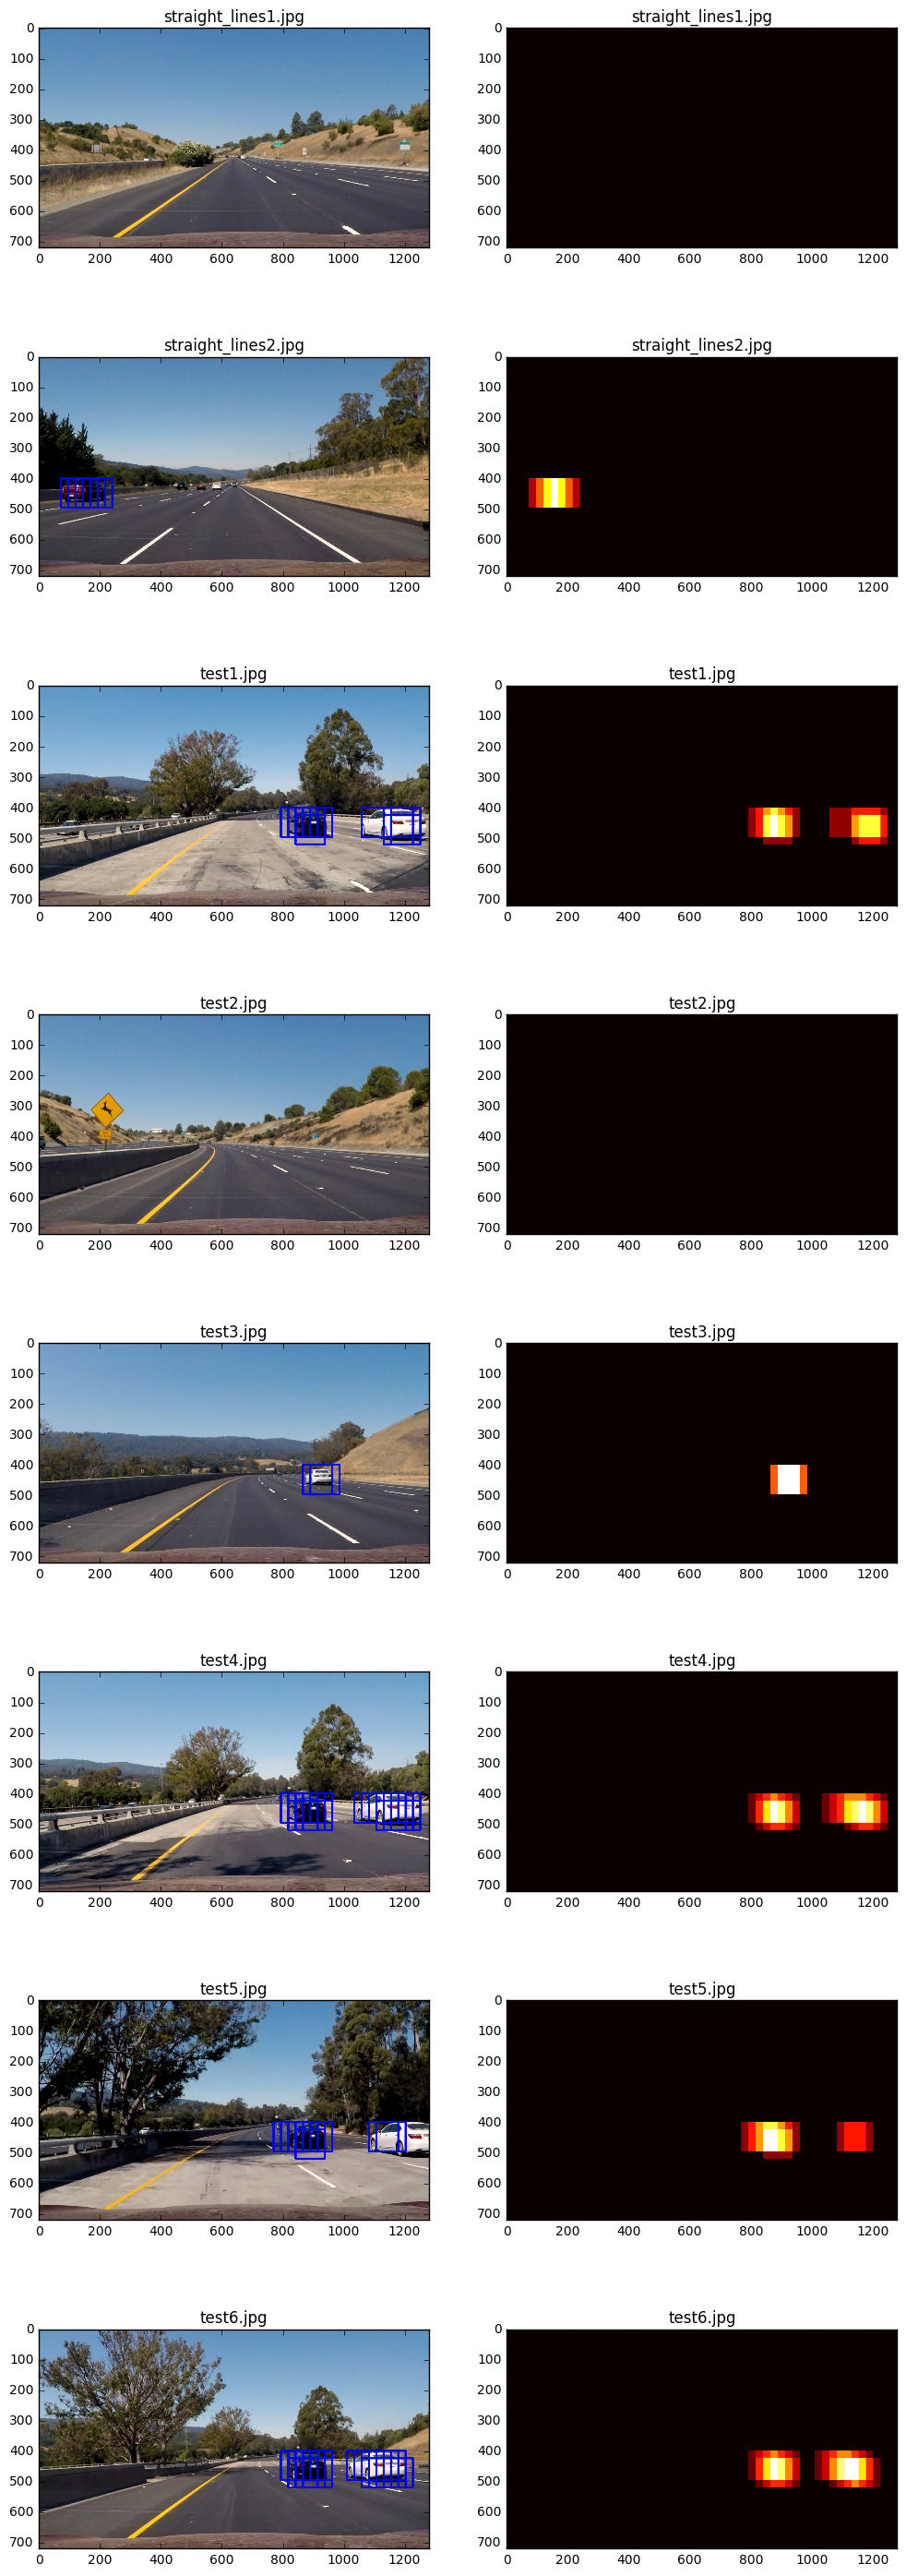

In [18]:
def find_cars2(img, ystart, ystop, scale):
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    print(np.min(img), np.max(img))

    y_start_stop = [None, None] # Min and max in y to search in slide_window()
    # provar 400, 656
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(128, 128), xy_overlap=(overlap, overlap))
                        # provar 64,64
                        # provar 96,96
    hot_windows = search_windows(img, windows, model, scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)                    
    images.append(window_img)

    return draw_img, heatmap, img_boxes

def test_find_cars2(example_images, ystart=400, ystop=656, scale=1.5):
    print("Testing Find Cars...")
    out_images = []
    out_maps = []
    out_titles = []
    out_boxes = []
    
    for img_src in example_images:
        t = time.time()
        count = 0
        img = mpimg.imread(img_src)
        draw_img, heatmap, img_boxes = find_cars2(img, ystart, ystop, scale)
        print(time.time()-t, 'seconds to run, total windows =', count)
        out_images.append(draw_img)
        title = img_src.split('/')[-1]
        out_titles.append(title)
        out_images.append(heatmap)
        out_titles.append(title)
        out_maps.append(heatmap)
        out_boxes.append(img_boxes)

    fig = plt.figure(figsize=(12, 36))
    visualize(fig, 8, 2, out_images, out_titles)
    
test_find_cars(example_images, 400, 656, 1.5)

Testing Draw Labeled BBoxes...


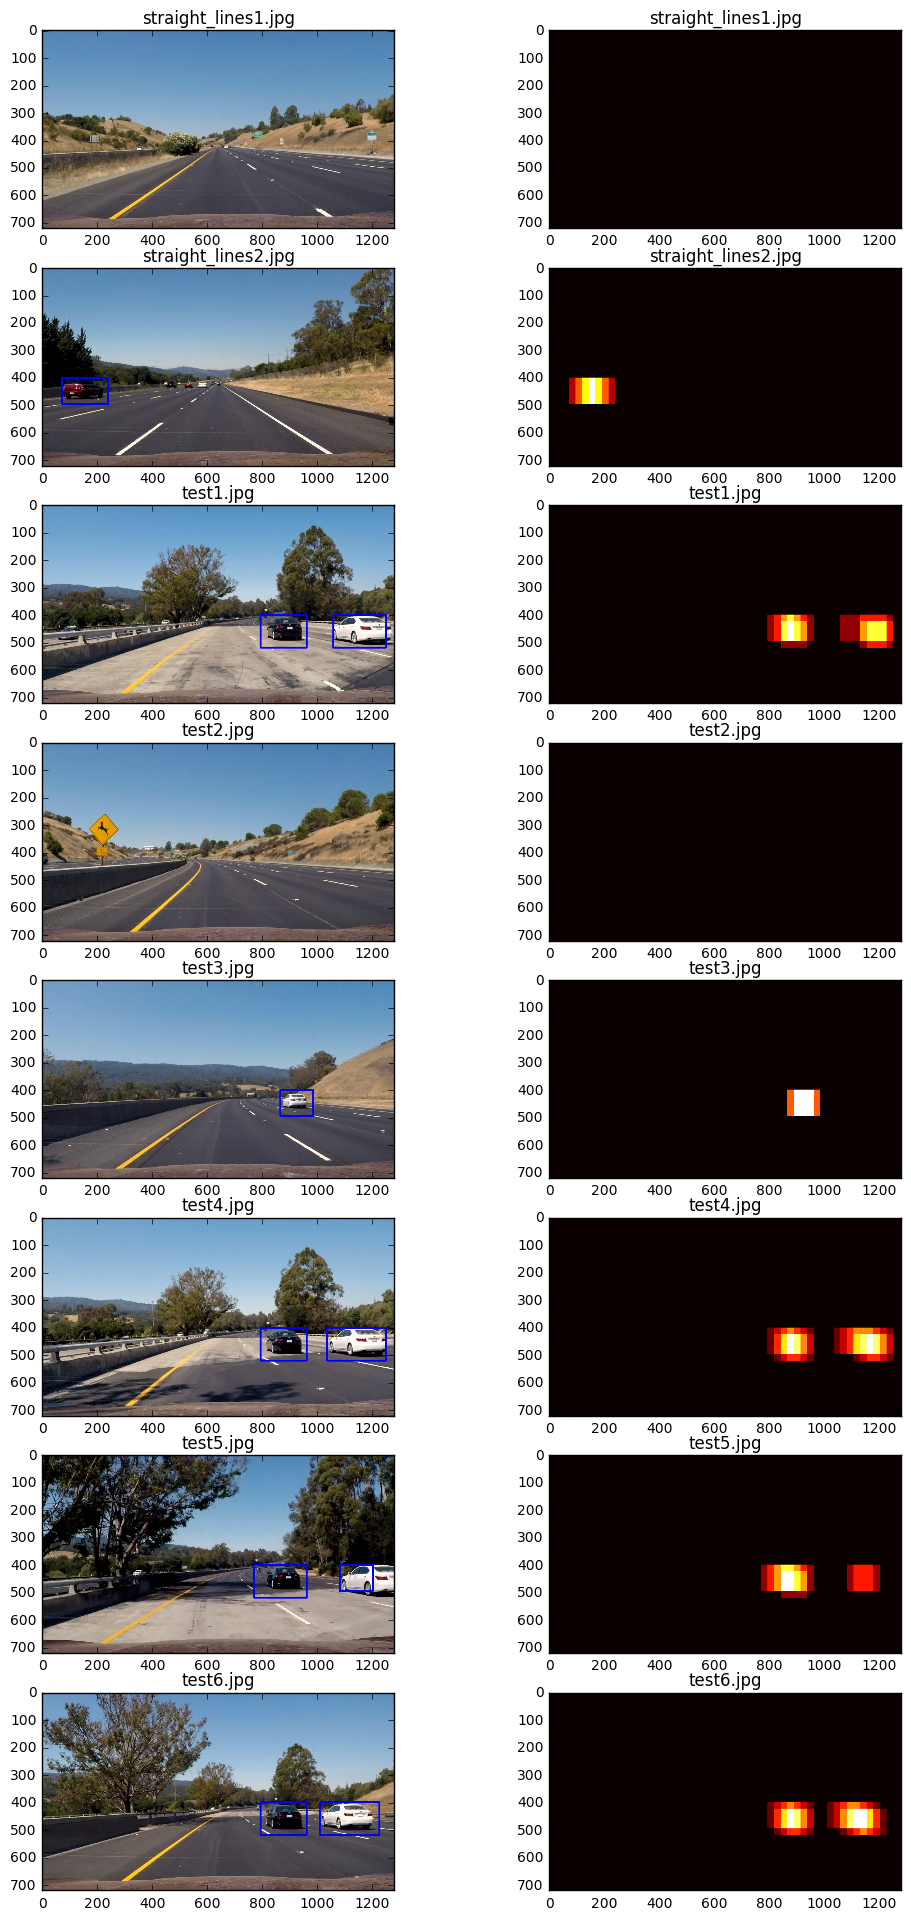

In [19]:
from scipy.ndimage.measurements import label

def draw_labeled_bboxes(image, labels):
    """
    Given an image and a list of detected cars, the
    function iterates through all detected cars:
      1. Find pixels with each car_number label value.
      2. Identify x and y values of those pixels.
      3. Define a bounding box based on min/max x and y.
      4. Draw the box on the image.
    Returns a copy of the image with bounding boxes.
    """
    img = np.copy(image)
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

def test_draw_labeled_bboxes(images, ystart=400, ystop=656, scale=1.5):
    print("Testing Draw Labeled BBoxes...")
    out_images = []
    out_maps = []
    out_titles = []

    for img_src in images:
        img = mpimg.imread(img_src)
        out_img, heatmap, _ = find_cars(img, ystart, ystop, scale)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(img, labels)
        out_images.append(draw_img)
        out_images.append(heatmap)
        title = img_src.split('/')[-1]
        out_titles.append(title)
        out_titles.append(title)

    fig = plt.figure(figsize=(12,24))
    visualize(fig, 8, 2, out_images, out_titles)

test_draw_labeled_bboxes(example_images, 400, 656, 1.5)

## Pipeline on a video stream

In [ ]:
def process_image(img):
    """
    Function to process a frame of the video.
    It returns the image with overlayed boxes on detected cars.
    """
    out_img, heatmap, _ = find_cars(img, 400, 656, 1.5)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(img, labels)
    return draw_img

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip = VideoFileClip("./test_video.mp4")
output_video = "./test.mp4"
output_clip = clip.fl_image(process_image)
output_clip.write_videofile(output_video, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))